$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$

# CS236605: Deep Learning
# Tutorial 6: Transfer Learning and Domain Adaptation

## Introduction

In this tutorial, we will cover:

- Transfer learning context(s)
- Leveraging pre-trained models
- Unsupervised domain adaptation

In [1]:
# Setup
%matplotlib inline
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Theory Reminders

### The supervised learning context

We have a labeled dataset of $N$ labelled samples: $\left\{ (\vec{x}^i,y^i) \right\}_{i=1}^N$, where
- $\vec{x}^i = \left(x^i_1, \dots, x^i_D\right) \in \mathcal{X}$  is a **sample** or **feature vector**.
- $y^i \in \mathcal{Y}$ is the **label**.
- For classification with $C$ classes, $\mathcal{Y} = \{0,\dots,C-1\}$, so each $y^i$ is a **class label**.
- Usually we assume each labeled sample $(\vec{x}^i,y^i)$
  is drawn from a joint distribution
  $$P(\rvec{X}, \rvar{Y})=P(\rvec{X})\cdot P(\rvar{Y}|\rvec{X})$$
    - We assume some marginal sample distribution $P(\rvar{X})$ exists.
    - We want to learn $P(\rvar{Y}|\rvec{X})$ from the data.

So far, we considered mostly the traditional **supervised learning** setting:

We assumed the **train** and **test** (which is supposed to represent future unseen data)
sets are both from the same **distribution** and both labeled.

We were able to assume this since we wanted to solve one task with one dataset, and we could
therefore split our dataset into such sets.

What happens when this is not the case?

## Transfer learning

In the real world, we often don't have the perfect training set for our problem.

What should we do when the supervised learning assumption is invalid?

<img src="img/transfer_learning_digits.png" width="700"/>

### Domains, targets and tasks

Lets start with some definitions to explain the problem.

- Imagine we have a **feature space**, $\mathcal{X}$
    - For example, $\mathcal{X}$ is the space of color images of size 32x32, each pixel in the range 0-255

In [2]:
import math
# size of this "limited" feature space
print(f'10^{math.log10(256**(32**2*3))}')

10^7398.1131734380015


- As usual, we have a training set $X=\{\vec{x}^{(i)}\}_{i=1}^{N},\ \vec{x}^{(i)}\in\cset{X}$.
    - For example, CIFAR-10
    
    <img src="img/cifar10.png" width="700"/>

- There exists some **probability distribution** $P(X)$ (aka $P_{X}(\vec{x})$) over our training set.
    - Note that we don't care about the distribution over $\cset{X}$.
    - For example, if $X$ is CIFAR-10, the probability of an all-black image should be very low
    - If classes are unbalanced, much different probabilities for members of large and small classes
    
    <img src="img/data_dist.jpg" width="800"/>

- Our **label space**, $\cset{Y}$ includes the possible labels for sample in our problem.
    - For example $\cset{Y}=\{0,1\}$ in binary classification.
- We may have also $Y = \{y^{(i)}\}_{i=1}^{N}$, the set of labels for our dataset.

- We want to learn the target function $\hat{y}=f(\vec{x})$ which predicts a label given an image.
    - From the probabilistic perspective, learn $P(\hat{y}|\vec{x})$.

Finally,
- A learning **domain** $\cset{D}$, is defined as $\cset{D}=\left\{\mathcal{X},P(X)\right\}$.
- A learning **task** $\cset{T}$ is defined as $\cset{T}=\{\cset{Y},P(Y|X)\}$.

### Transfer learning settings

**Definition** (Pan & Yang, 2010):

Given
- A **source** domain $\cset{D}_S$ and learning task $\cset{T}_S$
- A **target** domain $\cset{D}_T$ and learning task $\cset{T}_T$

*Transfer learning* aims to improve the learning of the target function
using *knowledge* in $\cset{D}_S$ and $\cset{T}_S$, when
- $\cset{D}_S \neq \cset{D}_T$, or
- $\cset{T}_S \neq \cset{T}_T$

Usually also there are other constraints on the target domain, such as little or no labels available.

When $\cset{D}_S=\cset{D}_T$ and $\cset{T}_S=\cset{T}_T$ we're in the regular supervised learning setting
we have seen thus far.

For example, splitting CIFAR-10 randomly into a train and test set.

#### Same domain, different task

Recall, a learning **task** $\cset{T}$ is defined as $\cset{T}=\{\cset{Y},P(Y|X)\}$.

So there are two cases (not mutually exclusive).

Case 1: The label spaces are different, $\cset{Y}_S \neq \cset{Y}_T$

For example, target domain has more classes.

<img src="img/cifar10_100.png" width="900"/>

Case 2: The target conditional distributions are different, $P(Y_S|X_S)\neq P(Y_T|X_T)$.

This may be the case when the class-balance is very different in the source and target distributions.

#### Same task, different domain

Recall, a learning **domain** $\cset{D}$, is defined as $\cset{D}=\left\{\mathcal{X},P(X)\right\}$.

Again, two cases.

Case 1: Different feature spaces, $\cset{X}_S \neq \cset{X}_T$.

For example: $\cset{X}_S$ is a space of grayscale images while $\cset{X}_T$ is a space of color images;
documents in different languages.

Case 2: Different data distributions, $P(X_S)\neq P(X_T)$.

For example: source domain contains hand-drawn images, while target domain contains photographs;
documents in the same language about different topics.

<img src="img/tl_example.png" width="400"/>

This is a very common scenario, and usually called **domain adaptation**.

TL is a huge research field.

<img src="img/pan_yang.png" width="1000" />

In this tutorial we'll see two simple yet common examples.

## Part 1: Fine-tuning a pre-trained model

We have trained trained a model in a source domain,
and now we want to use it to speed up training for a different domain.

In some applications, we may have have much less labeled data in the target domain, making it infeasible to train a deep model from scratch.

Common example: pre-train on ImageNet (1M+ images, 1000 classes), and then classify e.g. medical images.

<img src="img/transfer-learning-medical.png" width="700" />


Why would this work?

CNNs capture hierarchical features, with deeper layers capturing higher-level, class-specific features
(Zeiler & Fergus, 2013).

<img src="img/zf1.png" width="900"/>

<img src="img/zf2.png" width="1400"/>

Hence, we can start from a pre-trained model and,
- "Fine-tune" the convolutional filters, mainly in the deeper layers.
- Change the classifier "head" (or completely remove it) to fit our task and train it from scratch.

In [3]:
import torchvision as tv

# Load a deep CNN pretrained on ImageNet
# Using ResNet18 just to reduce download size, use something deeper
resnet18 = tv.models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [4]:
# Freeze all layers: disable gradient tracking
for p in resnet18.parameters():
    p.requires_grad = False

In [5]:
# "Thaw" last layer (or whatever is relevant for you)
for p in resnet18.layer4.parameters():
    p.requires_grad = True

In [6]:
import torch.optim

# Another way to freeze: zero learning rates for specific parameters
opt = torch.optim.SGD([
    dict(params=resnet18.layer1.parameters(), lr=0),
    dict(params=resnet18.layer2.parameters(), lr=0),
    dict(params=resnet18.layer3.parameters(), lr=0),
    dict(params=resnet18.layer4.parameters(), lr=1e-4),
    dict(params=resnet18.fc.parameters()),
], lr=1e-2, momentum=0.9)

In [7]:
import torch.nn as nn

# Replace fully-connected part by some other classifier, e.g.

cnn_features = resnet18.fc.in_features
num_classes = 13

resnet18.fc =  nn.Sequential(
    nn.Linear(cnn_features, 100, bias=True),
    nn.ReLU(),
    nn.Linear(100, num_classes, bias=True),
)

In [8]:
import torchvision.transforms as tvtf

# Important nuance 1: need to scale our data same as ImageNet training data
tf = tvtf.Compose([
    tvtf.Resize(224),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load our target domain data (CIFAR-10 used just as a simple example)
ds_train = tv.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tf)
ds_test = tv.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tf)

batch_size = 8
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
resnet18(ds_train[0][0].unsqueeze(dim=0))

tensor([[-0.3393,  0.3295, -0.1578,  0.0711,  0.3648,  0.0120,  0.1108, -0.2397,
         -0.2669,  0.0617, -0.3212,  0.0277,  0.4796]],
       grad_fn=<AddmmBackward>)

In [10]:
import torch.optim as optim

# Important nunance 2: Only parameters that track gradients can be passed into the optimizer
params_non_frozen = filter(lambda p: p.requires_grad, resnet18.parameters())
opt = optim.SGD(params_non_frozen, lr=0.05, momentum=0.9)

# Finetuning usually means we want smaller than usual learning rates and 
# decaying them in order to keep improving the weights
lr_sched = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.05, patience=5,)

loss_fn = nn.CrossEntropyLoss()

def train(model, loss_fn, opt, lr_sched, dl_train, dl_test):
    # Same as regular classifier traning, just call lr_sched.step() every epoch.
    # ...
    pass

## Part 2: Unsupervised domain adaptation

Let's consider a problem with different domains but an identical task:

- Source domain: MNIST
- Target domain: MNIST-M, a colored and textured version of MNIST

Task in both cases is the usual 10-class digit classification.

<img src="img/mnist_m.png" />

**Unsupervised** DA setting:
We assume that there are **no available labels** for the target domain.

We need to force our CNN to learn features of the digis shapes only, not color distributions.

Our approach, (based on Ganin et al. 2015):

- Train a classifier for the **domain** of an image based on deep convolutonal features.
- Try to maximize the loss of this classifier when training the CNN (**confusion loss**).
- Simultaneously, minimize the classification loss on the source domain using the same convolutional features.
- Train the digit classifier with source domain data, and the domain classifier with both domains' data.

<img src="img/ganin_da.png" width="1400" />

### Source and target domain data

Note: for the next block to run, you should manually [download](https://drive.google.com/open?id=0B_tExHiYS-0veklUZHFYT19KYjg) the MNIST-M dataset and unpack it into `data_dir`.

In [12]:
from tut6.data import MNISTMDataset

image_size = 28
batch_size = 4

tf_source = tvtf.Compose([
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=(0.1307,), std=(0.3081,))
])
tf_target = tvtf.Compose([
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

ds_source = tv.datasets.MNIST(root=data_dir, train=True, transform=tf_source, download=True)
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)

ds_target = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_train'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_train_labels.txt'),
                         transform=tf_target)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

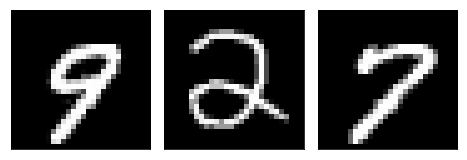

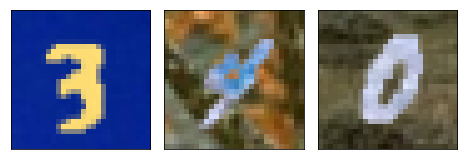

In [13]:
from tut6.plot_utils import dataset_first_n

dataset_first_n(ds_source, 3, cmap='gray');
dataset_first_n(ds_target, 3);

### Model

Our model will consist of three parts, as in the figure:
- A "deep" CNN for image feature extraction (2x Conv, ReLU, MaxPool)
- A digit-classification head (3x FC, ReLU)
- A domain classification head (2x FC, ReLU), with **gradient reversal layer** (GRL).


<img src="img/ganin_da2.png" width="1400" />


Recall: GRL is no-op in forward pass, but applies $-\lambda$ factor to gradient in the backward pass.

How can we implement this?

In [15]:
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

In [16]:
class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50), nn.Dropout2d(), nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.Dropout2d(),
            nn.ReLU(True),
            nn.Linear(100, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

Wait, but why let $\lambda$ (`grl_lambda` in the code) change during training (e.g. every epoch)?

- In the beginning of training, the domain loss is extremely noisy since the CNN features are not good yet.
- Therefore, lambda is gradulaly changed from 0 to 1 in the course of training.
    $$
    \lambda_p = \frac{2}{1+\exp(-10\cdot p)} -1,
    $$
    where $p\in[0,1]$ is the training progress.

In [17]:
model = DACNN()

x0_s, y0_s = next(iter(dl_source))
x0_t, y0_t = next(iter(dl_target))

print('source domain: ', x0_s.shape, y0_s.shape)
print('target domain: ', x0_t.shape, y0_t.shape)

model(x0_s)
model(x0_t)

source domain:  torch.Size([4, 1, 28, 28]) torch.Size([4])
target domain:  torch.Size([4, 3, 28, 28]) torch.Size([4])


(tensor([[-2.3871, -2.0135, -2.6594, -2.3351, -2.6167, -2.5896, -1.9831, -2.3627,
          -1.9416, -2.4720],
         [-2.1184, -2.3197, -2.3218, -2.4503, -2.5570, -2.1713, -2.4280, -2.1596,
          -2.3536, -2.2355],
         [-2.2772, -2.3747, -2.3180, -2.3140, -2.6862, -2.6952, -1.7384, -2.6459,
          -2.2026, -2.1704],
         [-2.6372, -2.7048, -2.2429, -2.0046, -2.2479, -2.1448, -2.3381, -2.4679,
          -2.3502, -2.1089]], grad_fn=<LogSoftmaxBackward>),
 tensor([[-0.8876, -0.5304],
         [-0.8818, -0.5345],
         [-0.9733, -0.4745],
         [-0.6405, -0.7487]], grad_fn=<LogSoftmaxBackward>))

### Training

In [18]:
lr = 1e-3
n_epochs = 1

# Setup optimizer as usual
model = DACNN()
optimizer = optim.Adam(model.parameters(), lr)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

In [19]:
batch_size = 1024
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target))

In [20]:
for epoch_idx in range(n_epochs):
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)

    for batch_idx in range(max_batches):
        optimizer.zero_grad()
        # Training progress and GRL lambda
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(dl_source_iter)
        y_s_domain = torch.zeros(batch_size, dtype=torch.long) # generate source domain labels

        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s)
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)

        # Train on target domain
        X_t, _ = next(dl_target_iter) # ignore target domain class labels!
        y_t_domain = torch.ones(batch_size, dtype=torch.long) # generate target domain labels

        _, domain_pred = model(X_t, grl_lambda)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)
        
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()
        
        print(f'[{batch_idx+1}/{max_batches}] '
              f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
              f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
             )
        if batch_idx == 2:
            print('This is just a demo, stopping...')
            break

Epoch 0001 / 0001
[1/58] class_loss: 2.3298 s_domain_loss: 0.7261 t_domain_loss: 0.6733 grl_lambda: 0.000 
[2/58] class_loss: 2.2447 s_domain_loss: 0.7014 t_domain_loss: 0.6873 grl_lambda: 0.086 
[3/58] class_loss: 2.1779 s_domain_loss: 0.6790 t_domain_loss: 0.7027 grl_lambda: 0.171 
This is just a demo, stopping...


**Image credits**

Some images in this tutorial were taken and/or adapted from:

- Pan & Yang, 2010, A Survey on Transfer Learning
- Zeiler & Fergus, 2013, Visualizing and Understanding Convolutional Networks
- Y. Ganin et al. 2015, Unsupervised Domain Adaptation by Backpropagation 
- M. Wulfmeier et al., https://arxiv.org/abs/1703.01461v2
- Sebastian Ruder, http://ruder.io/